In [1]:
import helper.training_preprocess as tp
from helper.evaluator import Evaluator
from helper.trajectory import Trajectory
from models.stonesoup_radar_sim import StonesoupRadarSim
import numpy as np
import pickle
from tqdm import tqdm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
with open("../../dataset/dataframe-readins/full_traj_data.pkl", "rb") as f:
    test_traj_data = pickle.load(f)

In [3]:
def store_truth_data(aDF):
    truth_data = {}
    truth_data['timestamps'] = np.array(aDF['timestamp'])
    truth_data['x'] = np.array(aDF['tx'])
    truth_data['y'] = np.array(aDF['ty'])
    truth_data['z'] = np.array(aDF['tz'])
    truth_data['vx'] = np.array(aDF['vx'])
    truth_data['vy'] = np.array(aDF['vy'])
    truth_data['vz'] = np.array(aDF['vz'])
    return truth_data

In [4]:
# Measurement Simulation Inputs
show_radar_meas = True
moe = True 
traj_no = 10
test_traj_df = test_traj_data[traj_no]
display(test_traj_df)
truth_data = store_truth_data(test_traj_df)

,timestamp,tx,ty,tz,vx,vy,vz,delta_time
0,0.000000,29.697573,35.332264,7.143993,0.191340,0.149210,-0.190093,0.100000
1,0.100000,29.716707,35.347185,7.124984,0.221273,0.163773,-0.125057,0.100000
2,0.200000,29.738834,35.363562,7.112478,0.209610,0.138420,-0.023402,0.100000
3,0.300000,29.759795,35.377404,7.110138,0.210690,0.065097,0.115749,0.100000
4,0.400000,29.780864,35.383914,7.121713,0.114083,0.075307,0.165397,0.100000
...,...,...,...,...,...,...,...,...
209,20.899981,27.934460,36.896906,7.037593,2.151481,-1.309362,-0.022967,0.100000
210,20.999981,28.149609,36.765969,7.035296,2.053809,-1.222295,-0.026094,0.099998
211,21.099979,28.354987,36.643741,7.032687,2.230256,-1.296377,0.003616,0.100000
212,21.199980,28.578013,36.514103,7.033049,1.982299,-1.165592,0.048736,0.100000


In [5]:
%%time
TestTraj = Trajectory(truth_data, traj_no, measurement_only_eval=moe)
TestTraj.apply_sampling_gaps(remove_pct=0)
TestTraj.visualize_3d_trajectory()

CPU times: total: 0 ns
Wall time: 5 ms


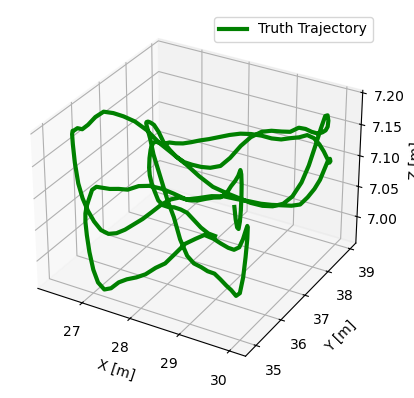

In [6]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D line
ax.plot(TestTraj.truth_x, TestTraj.truth_y, TestTraj.truth_z, label='Truth Trajectory', color='g', linewidth=3)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.legend()

# Show the plot
plt.savefig('../../report/images/3d_truth.png', dpi=300)  # or use .pdf, .svg, etc.
plt.show()

## Radar Measurements

In [7]:
TestSim = StonesoupRadarSim(proc_noise=0.1, sensor_noise_level='mid', include_range_rate=True)
test_radar_meas = TestSim.simulate_radar_measurements(TestTraj)

In [8]:
print(len(test_radar_meas))
print(len(TestTraj.truth_x))

214
214


In [9]:
elevations = []
bearings = []
ranges = []
range_rates = []
for meas in test_radar_meas:
    elevations.append(meas.state_vector[0])
    bearings.append(meas.state_vector[1])
    ranges.append(meas.state_vector[2])
    range_rates.append(meas.state_vector[3])

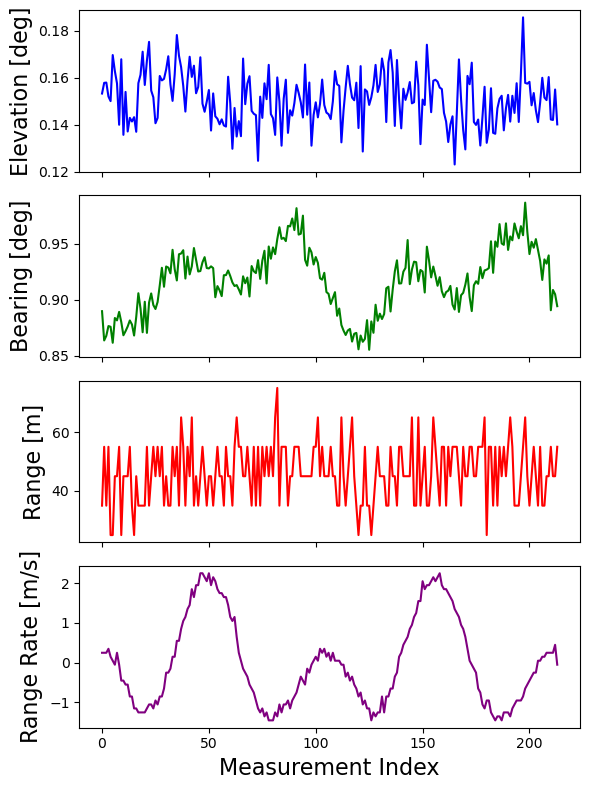

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
indices = list(range(len(elevations)))

axs[0].plot(indices, elevations, label='Elevation', color='blue')
axs[0].set_ylabel('Elevation [deg]', fontsize = 16)

axs[1].plot(indices, bearings, label='Bearing', color='green')
axs[1].set_ylabel('Bearing [deg]', fontsize = 16)

axs[2].plot(indices, ranges, label='Range', color='red')
axs[2].set_ylabel('Range [m]', fontsize = 16)

axs[3].plot(indices, range_rates, label='Range Rate', color='purple')
axs[3].set_ylabel('Range Rate [m/s]', fontsize = 16)
axs[3].set_xlabel('Measurement Index', fontsize = 16)

plt.tight_layout()
plt.savefig('../../report/images/corresponding_radar_meas_example.png', dpi=300)  # or use .pdf, .svg, etc.
plt.show()

## Example Noise

In [11]:
sensor_noise_levels = ['low', 'mid', 'high']
xyz_data = {}
for noise_level in sensor_noise_levels:
    TestSim = StonesoupRadarSim(proc_noise=0.1, sensor_noise_level=noise_level, include_range_rate=True)
    test_radar_meas = TestSim.simulate_radar_measurements(TestTraj)
    converted_state_vecs, measurement_conversion_data = TestSim.convert_radar_observations_to_cartesian(test_radar_meas)
    xyz_data[noise_level] = converted_state_vecs

In [12]:
print(len(xyz_data['low'][0]))

6


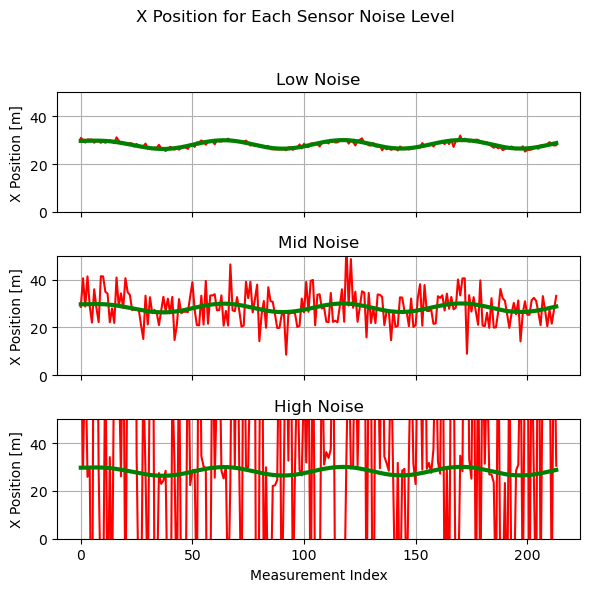

In [13]:
# Extract X truth trajectory as array
truth_x = TestTraj.truth_x

# Create a 3x1 subplot: one for each noise level
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
noise_labels = ['low', 'mid', 'high']
y_limits = [(0, 50), (0, 50), (0, 50)]

for i, (noise_level, ax) in enumerate(zip(noise_labels, axes)):
    # Stack data for this noise level into numpy array
    data = np.stack(xyz_data[noise_level], axis=1)  # shape: (3, T)
    x_data = data[0]  # X component

    # Plot noisy X data
    ax.plot(x_data, label=f'{noise_level} noise', color='red')
    
    # Plot ground-truth X data
    ax.plot(truth_x, label='Truth', color='green', linewidth=3)

    ax.set_ylabel('X Position [m]')
    ax.set_title(f'{noise_level.capitalize()} Noise')
    ax.set_ylim(*y_limits[i])  # Set subplot-specific y-range
    ax.grid(True)

axes[-1].set_xlabel('Measurement Index')
fig.suptitle('X Position for Each Sensor Noise Level')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../../report/images/x_position_noise_levels.png', dpi=300)  # or use .pdf, .svg, etc.
plt.show()